In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Corporate styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Dataset Shape: (2260701, 151)
Memory Usage: 5947.77 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 151 columns):
 #    Column                                      Non-Null Count    Dtype  
---   ------                                      --------------    -----  
 0    id                                          2260701 non-null  object 
 1    member_id                                   0 non-null        float64
 2    loan_amnt                                   2260668 non-null  float64
 3    funded_amnt                                 2260668 non-null  float64
 4    funded_amnt_inv                             2260668 non-null  float64
 5    term                                        2260668 non-null  object 
 6    int_rate                                    2260668 non-null  float64
 7    installment                                 2260668 non-null  float64
 8    grade                                       2260668 non-null  obj

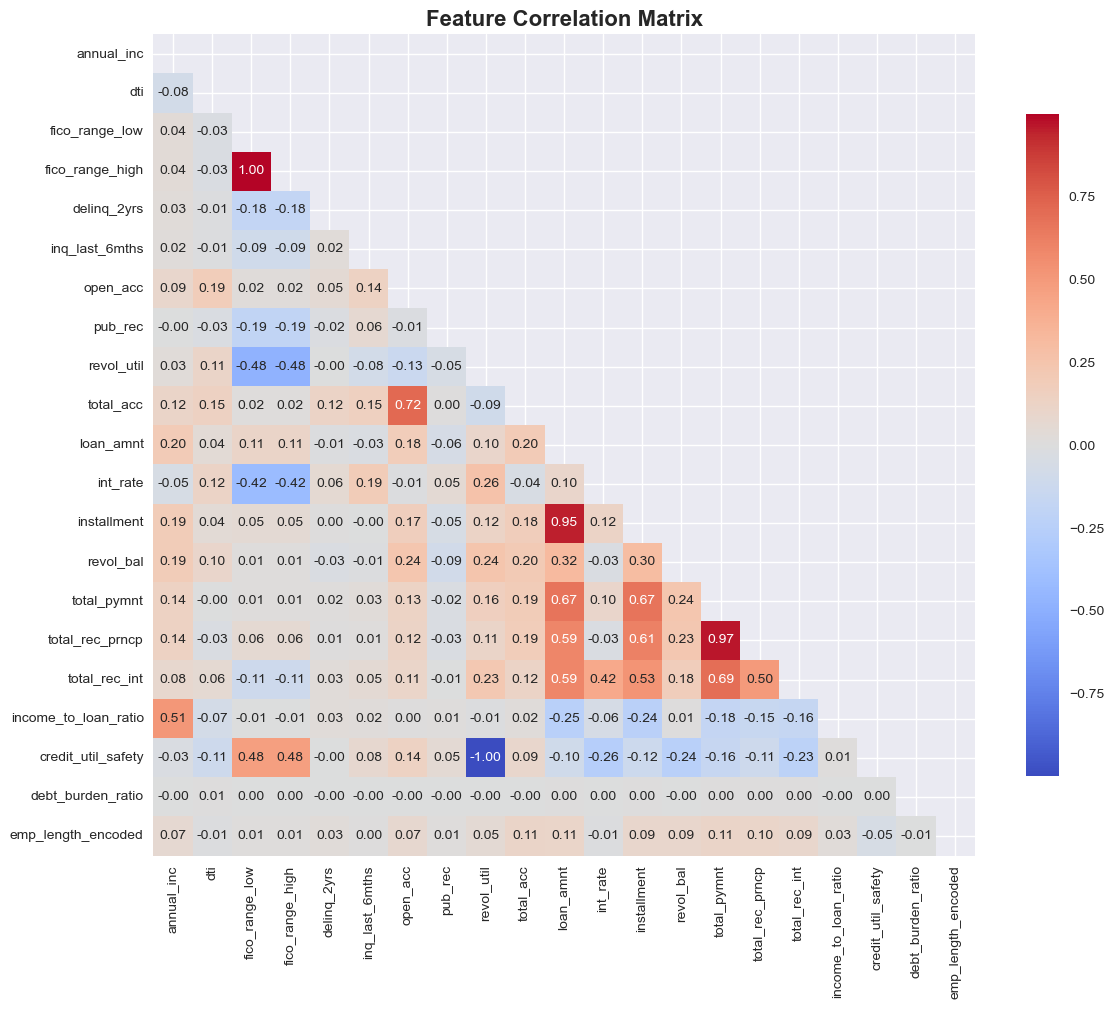


💡 BUSINESS INSIGHTS

1. Default rates by grade:
grade
G    0.4133
F    0.3710
E    0.2886
D    0.2080
C    0.1466
B    0.0885
A    0.0369
Name: default, dtype: float64

2. Verification status impact:
verification_status
Not Verified       0.091690
Source Verified    0.135906
Verified           0.172255
Name: default, dtype: float64

3. Risk by loan purpose:
purpose
educational         0.360849
small_business      0.208635
renewable_energy    0.167474
moving              0.161073
wedding             0.142251
Name: default, dtype: float64

4. Risk by FICO category:
fico_category
Fair         0.181754
Good         0.125142
Very Good    0.057110
Excellent    0.037159
Poor              NaN
Name: default, dtype: float64


In [15]:
class CorporateLoanAnalyzer:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.feature_importance = {}
        
    def load_data(self):
        
        self.df = pd.read_csv(self.data_path)
        print(f"Dataset Shape: {self.df.shape}")
        print(f"Memory Usage: {self.df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Basic info
        print(self.df.info(verbose=True, show_counts=True))
        
        return self.df
    
    def analyze_target_variable(self):
        
        status_mapping = {
            'Fully Paid': 0,
            'Current': 0,  
            'Charged Off': 1,
            'Default': 1,
            'Late (31-120 days)': 1,
            'In Grace Period': 0 
        }
        
        self.df['default'] = self.df['loan_status'].map(status_mapping)
        
        unmapped = self.df[self.df['default'].isna()]['loan_status'].unique()
        if len(unmapped) > 0:
            print(f"Unmapped statuses: {unmapped}")
            self.df['default'] = self.df['default'].fillna(1)
        
        default_rate = self.df['default'].mean()
        print(f"Overall Default Rate: {default_rate:.2%}")
        print(f"Class Distribution:\n{self.df['default'].value_counts()}")
        
        return default_rate
    
    def corporate_feature_selection(self):

        feature_categories = {
            'financial_capacity': [
                'annual_inc', 'dti', 'emp_length', 'home_ownership', 
                'verification_status'
            ],
            'credit_history': [
                'fico_range_low', 'fico_range_high', 'delinq_2yrs', 
                'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
                'total_acc', 'earliest_cr_line'
            ],
            'loan_characteristics': [
                'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
                'purpose', 'installment'
            ],
            'behavioral_metrics': [
                'revol_bal', 'total_pymnt', 'total_rec_prncp', 'total_rec_int'
            ]
        }
        
        selected_features = []
        for category, features in feature_categories.items():
            available_features = [f for f in features if f in self.df.columns]
            print(f" {category.upper()}: {available_features}")
            selected_features.extend(available_features)
      
        selected_features.extend(self.create_business_features())
        
        print(f"\n FINAL FEATURE SET ({len(selected_features)} features):")
        print(selected_features)
        
        return selected_features
    
    def create_business_features(self):

        # Income to loan ratio
        self.df['income_to_loan_ratio'] = self.df['annual_inc'] / self.df['loan_amnt']
        
        # Credit utilization safety margin
        self.df['credit_util_safety'] = 100 - self.df['revol_util']
        self.df['credit_util_safety'] = self.df['credit_util_safety'].fillna(0)
        
        # Debt burden ratio
        self.df['debt_burden_ratio'] = self.df['installment'] / (self.df['annual_inc'] / 12)
        
        # Employment length encoding
        emp_length_mapping = {
            '< 1 year': 0,
            '1 year': 1,
            '2 years': 2,
            '3 years': 3,
            '4 years': 4,
            '5 years': 5,
            '6 years': 6,
            '7 years': 7,
            '8 years': 8,
            '9 years': 9,
            '10+ years': 10
        }
        self.df['emp_length_encoded'] = self.df['emp_length'].map(emp_length_mapping)
        self.df['emp_length_encoded'] = self.df['emp_length_encoded'].fillna(-1)

        self.df['fico_category'] = pd.cut(
            self.df['fico_range_low'], 
            bins=[0, 580, 670, 740, 800, 850],
            labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
        )
        
        engineered_features = [
            'income_to_loan_ratio', 'credit_util_safety', 
            'debt_burden_ratio', 'emp_length_encoded', 'fico_category'
        ]
        
        print(f"Engineered Features: {engineered_features}")
        
        return engineered_features
    
    def handle_missing_data(self, features):

        
        missing_data = self.df[features].isnull().sum()
        missing_pct = (missing_data / len(self.df)) * 100
        
        missing_info = pd.DataFrame({
            'missing_count': missing_data,
            'missing_percentage': missing_pct
        }).sort_values('missing_percentage', ascending=False)
        
        print("Missing Data Summary:")
        print(missing_info[missing_info['missing_count'] > 0])
        
        # Imputation strategy
        for feature in features:
            if feature in self.df.columns:
                if self.df[feature].isnull().sum() > 0:
                    if self.df[feature].dtype in ['float64', 'int64']:
                        # Use median for numerical features
                        self.df[feature].fillna(self.df[feature].median(), inplace=True)
                    else:
                        # Use mode for categorical features
                        self.df[feature].fillna(self.df[feature].mode()[0], inplace=True)
    

    
    def analyze_feature_correlations(self, features):
        """Comprehensive correlation analysis"""
        print("\n📈 FEATURE CORRELATION ANALYSIS")
        
        numerical_features = self.df[features].select_dtypes(include=[np.number]).columns
        
        target_correlations = self.df[numerical_features].corrwith(self.df['default']).abs().sort_values(ascending=False)
        print("Feature correlations with default risk:")
        print(target_correlations.head(10))
        
        # Feature correlation matrix
        plt.figure(figsize=(12, 10))
        correlation_matrix = self.df[numerical_features].corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return target_correlations
    
    def generate_business_insights(self):
        """Generate actionable business insights"""
        print("\n💡 BUSINESS INSIGHTS")
        
        insights = []
    
        default_by_grade = self.df.groupby('grade')['default'].mean().sort_values(ascending=False)
        insights.append(f"Default rates by grade:\n{default_by_grade.round(4)}")
        
        verification_impact = self.df.groupby('verification_status')['default'].mean()
        insights.append(f"Verification status impact:\n{verification_impact}")
        
        purpose_risk = self.df.groupby('purpose')['default'].mean().sort_values(ascending=False)
        insights.append(f"Risk by loan purpose:\n{purpose_risk.head()}")
        
        fico_risk = self.df.groupby('fico_category')['default'].mean().sort_values(ascending=False)
        insights.append(f"Risk by FICO category:\n{fico_risk}")
        
        for i, insight in enumerate(insights, 1):
            print(f"\n{i}. {insight}")
        
        return insights

analyzer = CorporateLoanAnalyzer('accepted_2007_to_2018Q4.csv')
df = analyzer.load_data()
default_rate = analyzer.analyze_target_variable()
selected_features = analyzer.corporate_feature_selection()
analyzer.handle_missing_data(selected_features)
correlations = analyzer.analyze_feature_correlations(selected_features)
insights = analyzer.generate_business_insights()

# Save processed data
df[selected_features + ['default', 'loan_status']].to_csv('processed_loan_data.csv', index=False)

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

class CorporateRiskModel:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_importance = {}
        
    def prepare_data(self, df, features, target='default'):
        
        X = df[features].copy()
        y = df[target].values
    
        # Data cleaning: Handle infinite and extremely large values
        for col in X.select_dtypes(include=[np.number]).columns:
            # Replace inf/-inf with NaN
            X[col] = X[col].replace([np.inf, -np.inf], np.nan)
            # Handle extremely large values (cap at 99.9th percentile)
            if X[col].notna().sum() > 0:
                p99 = X[col].quantile(0.999)
                if p99 != 0:
                    X[col] = np.where(X[col] > p99 * 100, p99, X[col])  # Cap extreme outliers
    
        # Handle categorical variables
        categorical_features = X.select_dtypes(include=['object']).columns
        for feature in categorical_features:
            le = LabelEncoder()
            X[feature] = le.fit_transform(X[feature].astype(str))
            self.label_encoders[feature] = le
    
        # Handle missing values after cleaning
        numerical_features = X.select_dtypes(include=[np.number]).columns
        for col in numerical_features:
            if X[col].isnull().sum() > 0:
                X[col].fillna(X[col].median(), inplace=True)
    
        print(f"Data shape after cleaning: {X.shape}")
    
        # Scale numerical features with robust error handling
        try:
            X[numerical_features] = self.scaler.fit_transform(X[numerical_features])

        except Exception as e:
            print(f"⚠️ Scaling failed: {e}")
        
            # Debug: Check for problematic columns
            for col in numerical_features:
                col_data = X[col]
                if col_data.isnull().any():
                    print(f"Column {col}: {col_data.isnull().sum()} null values")
                if np.isinf(col_data).any():
                    print(f"Column {col}: {np.isinf(col_data).sum()} infinite values")
                if (col_data > 1e10).any():
                    print(f"Column {col}: Extreme values detected")
        

            from sklearn.preprocessing import RobustScaler
            robust_scaler = RobustScaler()
            X[numerical_features] = robust_scaler.fit_transform(X[numerical_features])
            self.scaler = robust_scaler
    
        # Train-validation-test split with stratification
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
    
        print(f"Training set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        print(f"Test set: {X_test.shape}")
        print(f"Default rate - Train: {y_train.mean():.3f}, Val: {y_val.mean():.3f}, Test: {y_test.mean():.3f}")
    
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def create_advanced_model(self, input_dim):
        class AdvancedRiskModel(nn.Module):
            def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32], dropout_rate=0.3):
                super(AdvancedRiskModel, self).__init__()
                
                layers = []
                prev_dim = input_dim
                
                for hidden_dim in hidden_dims:
                    layers.extend([
                        nn.Linear(prev_dim, hidden_dim),
                        nn.BatchNorm1d(hidden_dim),
                        nn.ReLU(),
                        nn.Dropout(dropout_rate)
                    ])
                    prev_dim = hidden_dim
                
                # Output layer
                layers.append(nn.Linear(prev_dim, 1))
                layers.append(nn.Sigmoid())
                
                self.network = nn.Sequential(*layers)
                
                # Initialize weights
                self.apply(self._init_weights)
            
            def _init_weights(self, module):
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)
            
            def forward(self, x):
                return self.network(x).squeeze()
        
        return AdvancedRiskModel(input_dim)
    
    def train_with_early_stopping(self, model, train_loader, val_loader, criterion, optimizer, patience=10):
        train_losses = []
        val_losses = []
        val_auc_scores = []
        
        best_val_auc = 0
        best_model_state = None
        patience_counter = 0
        
        for epoch in range(200):  # Increased epochs for better convergence
            # Training phase
            model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                optimizer.step()
                train_loss += loss.item()
            
            train_losses.append(train_loss / len(train_loader))
            
            # Validation phase
            model.eval()
            val_loss = 0
            val_preds = []
            val_targets = []
            
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    val_loss += loss.item()
                    
                    val_preds.extend(outputs.numpy())
                    val_targets.extend(batch_y.numpy())
            
            val_losses.append(val_loss / len(val_loader))
            val_auc = roc_auc_score(val_targets, val_preds)
            val_auc_scores.append(val_auc)
            
            # Early stopping and model checkpointing
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/200], Train Loss: {train_losses[-1]:.4f}, '
                      f'Val Loss: {val_losses[-1]:.4f}, Val AUC: {val_auc:.4f}')
        
        # Load best model
        model.load_state_dict(best_model_state)
        
        return train_losses, val_losses, val_auc_scores, best_val_auc
    
    def evaluate_business_metrics(self, model, X_test, y_test, thresholds=np.arange(0.1, 0.9, 0.05)):
        
        model.eval()
        with torch.no_grad():
            test_probs = model(torch.FloatTensor(X_test)).numpy()
    
        business_metrics = []
        for threshold in thresholds:
            predictions = (test_probs > threshold).astype(int)

            f1 = f1_score(y_test, predictions)
            precision = precision_score(y_test, predictions)
            recall = recall_score(y_test, predictions)
            
            approval_rate = (predictions == 0).mean()  # Approve if low risk
            true_positive_rate = recall  # Correctly identified defaults
            false_positive_rate = 1 - precision_score(y_test, predictions, pos_label=0)
            
            business_metrics.append({
                'threshold': threshold,
                'f1_score': f1,
                'precision': precision,
                'recall': recall,
                'approval_rate': approval_rate,
                'true_positive_rate': true_positive_rate,
                'false_positive_rate': false_positive_rate
            })
        
        metrics_df = pd.DataFrame(business_metrics)
        
        optimal_idx = (metrics_df['f1_score'] * metrics_df['approval_rate']).idxmax()
        optimal_threshold = metrics_df.loc[optimal_idx, 'threshold']
        
        print(f"Optimal decision threshold: {optimal_threshold:.3f}")
        print(f"At this threshold:")
        print(f"  - Approval Rate: {metrics_df.loc[optimal_idx, 'approval_rate']:.3f}")
        print(f"  - F1 Score: {metrics_df.loc[optimal_idx, 'f1_score']:.3f}")
        print(f"  - Precision: {metrics_df.loc[optimal_idx, 'precision']:.3f}")
        print(f"  - Recall: {metrics_df.loc[optimal_idx, 'recall']:.3f}")
        
        self.plot_business_tradeoffs(metrics_df, optimal_threshold)
        
        return optimal_threshold, metrics_df
    
    def plot_business_tradeoffs(self, metrics_df, optimal_threshold):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        axes[0,0].plot(metrics_df['threshold'], metrics_df['approval_rate'], 
                      label='Approval Rate', linewidth=2)
        axes[0,0].plot(metrics_df['threshold'], metrics_df['recall'], 
                      label='Default Detection Rate', linewidth=2)
        axes[0,0].axvline(x=optimal_threshold, color='red', linestyle='--', 
                         label=f'Optimal Threshold: {optimal_threshold:.3f}')
        axes[0,0].set_xlabel('Decision Threshold')
        axes[0,0].set_ylabel('Rate')
        axes[0,0].set_title('Approval Rate vs Default Detection')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # F1 Score vs Threshold
        axes[0,1].plot(metrics_df['threshold'], metrics_df['f1_score'], 
                      linewidth=2, color='green')
        axes[0,1].axvline(x=optimal_threshold, color='red', linestyle='--')
        axes[0,1].set_xlabel('Decision Threshold')
        axes[0,1].set_ylabel('F1 Score')
        axes[0,1].set_title('F1 Score vs Decision Threshold')
        axes[0,1].grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, test_probs)
        axes[1,0].plot(recall, precision, linewidth=2)
        axes[1,0].set_xlabel('Recall')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].set_title('Precision-Recall Curve')
        axes[1,0].grid(True, alpha=0.3)
        
        # Feature Importance (using permutation)
        importance_scores = self.calculate_feature_importance(model, X_test, y_test, features)
        features_plot = list(importance_scores.keys())[:10]
        scores_plot = [importance_scores[f] for f in features_plot]
        
        axes[1,1].barh(features_plot, scores_plot)
        axes[1,1].set_xlabel('Permutation Importance')
        axes[1,1].set_title('Top 10 Feature Importance Scores')
        
        plt.tight_layout()
        plt.savefig('business_metrics_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def calculate_feature_importance(self, model, X, y, feature_names, n_repeats=20):
        baseline_auc = roc_auc_score(y, model(torch.FloatTensor(X)).detach().numpy())
        
        importance_scores = {}
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        
        for i, feature_name in enumerate(feature_names):
            scores = []
            for _ in range(n_repeats):
                X_permuted = X_np.copy()
                np.random.shuffle(X_permuted[:, i])
                permuted_score = roc_auc_score(y, model(torch.FloatTensor(X_permuted)).detach().numpy())
                scores.append(baseline_auc - permuted_score)
            
            importance_scores[feature_name] = np.mean(scores)
        
        return dict(sorted(importance_scores.items(), key=lambda x: x[1], reverse=True))


df = pd.read_csv('processed_loan_data.csv')
features = [col for col in df.columns if col not in ['default', 'loan_status']]

# Initialize and train model
risk_model = CorporateRiskModel()
X_train, X_val, X_test, y_train, y_val, y_test = risk_model.prepare_data(df, features)

# Handle class imbalance
class_weights = torch.tensor([1 / (1 - y_train.mean()), 1 / y_train.mean()])
weighted_sampler = WeightedRandomSampler(
    weights=class_weights[y_train.astype(int)],
    num_samples=len(y_train),
    replacement=True
)

# Create data loaders
train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=128, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize model
model = risk_model.create_advanced_model(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

train_losses, val_losses, val_auc_scores, best_auc = risk_model.train_with_early_stopping(
    model, train_loader, val_loader, criterion, optimizer, patience=15
)

print(f"🎯 BEST VALIDATION AUC: {best_auc:.4f}")

# Business evaluation
optimal_threshold, metrics_df = risk_model.evaluate_business_metrics(model, X_test, y_test)

# Save model artifacts
torch.save(model.state_dict(), 'corporate_risk_model.pth')
joblib.dump(risk_model.scaler, 'scaler.pkl')
joblib.dump(risk_model.label_encoders, 'label_encoders.pkl')


Data shape after cleaning: (2260701, 30)
Training set: (1582490, 30)
Validation set: (339105, 30)
Test set: (339106, 30)
Default rate - Train: 0.131, Val: 0.131, Test: 0.131
Epoch [20/200], Train Loss: 0.2265, Val Loss: 0.1884, Val AUC: 0.9746
Epoch [40/200], Train Loss: 0.2180, Val Loss: 0.1662, Val AUC: 0.9755


KeyboardInterrupt: 

## Reinforcement Learning

In [ ]:
import pandas as pd
import numpy as np
import torch
import gym
from gym import spaces
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import warnings
warnings.filterwarnings('ignore')

class CorporateLoanEnvironment(gym.Env):
    
    def __init__(self, df_processed, original_df, feature_cols, 
                 capital_constraint=1000000, risk_tolerance=0.05):
        super(CorporateLoanEnvironment, self).__init__()
        
        self.df_processed = df_processed.reset_index(drop=True)
        self.original_df = original_df.reset_index(drop=True)
        self.feature_cols = feature_cols
        
        # Business constraints
        self.capital_constraint = capital_constraint
        self.risk_tolerance = risk_tolerance
        self.allocated_capital = 0
        
        # RL spaces
        self.action_space = spaces.Discrete(2)  # 0: Deny, 1: Approve
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(feature_cols) + 2,), dtype=np.float32
        )  # Added features for portfolio state
        
        self.current_step = 0
        self.max_steps = len(df_processed)
        self.approved_loans = []
        
    def reset(self):
        self.current_step = 0
        self.allocated_capital = 0
        self.approved_loans = []
        return self._get_observation()
    
    def step(self, action):
        state = self._get_observation()
        
        # Get loan details
        loan_amount = self.original_df.loc[self.current_step, 'loan_amnt']
        interest_rate = self.original_df.loc[self.current_step, 'int_rate'] / 100
        actual_default = self.df_processed.loc[self.current_step, 'default']
        
        reward = 0
        info = {}
        
        if action == 1:  # Approve
            # Check capital constraint
            if self.allocated_capital + loan_amount > self.capital_constraint:
                reward = -10  # Heavy penalty for exceeding capital
                info['reason'] = 'capital_exceeded'
            else:
                self.allocated_capital += loan_amount
                self.approved_loans.append({
                    'amount': loan_amount,
                    'interest_rate': interest_rate,
                    'defaulted': actual_default
                })
                
                # Calculate reward with business logic
                if actual_default == 0:  # Paid
                    reward = loan_amount * interest_rate  # Profit from interest
                    info['outcome'] = 'profit'
                else:  # Defaulted
                    reward = -loan_amount * 1.2  # Loss + recovery costs
                    info['outcome'] = 'loss'
                
                # Risk-based adjustment
                portfolio_risk = self._calculate_portfolio_risk()
                if portfolio_risk > self.risk_tolerance:
                    reward *= 0.5  # Reduce reward for risky portfolio
        else:  # Deny
            reward = 0
            info['outcome'] = 'denied'
            
            # Small penalty for denying good loans
            if actual_default == 0 and interest_rate > 0.08:  # Good loan with decent interest
                reward = -loan_amount * interest_rate * 0.1  # Opportunity cost
        
        # Move to next step
        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        # Additional info for business analysis
        info.update({
            'step': self.current_step,
            'allocated_capital': self.allocated_capital,
            'portfolio_risk': self._calculate_portfolio_risk(),
            'approved_count': len(self.approved_loans)
        })
        
        return state, reward, done, info
    
    def _get_observation(self):
        base_features = self.df_processed.loc[self.current_step, self.feature_cols].values.astype(np.float32)
        
        # Add portfolio-level features
        capital_utilization = self.allocated_capital / self.capital_constraint
        current_risk = self._calculate_portfolio_risk()
        
        enhanced_features = np.append(base_features, [capital_utilization, current_risk])
        return enhanced_features
    
    def _calculate_portfolio_risk(self):
        if not self.approved_loans:
            return 0.0
        
        total_approved = sum(loan['amount'] for loan in self.approved_loans)
        if total_approved == 0:
            return 0.0
        
        # Weighted average default probability (simplified)
        risk_score = sum(
            loan['amount'] * loan['defaulted'] for loan in self.approved_loans
        ) / total_approved
        
        return risk_score
    
    def render(self, mode='human'):
        if mode == 'human':
            print(f"Step: {self.current_step}, Capital Used: {self.allocated_capital:,.0f}, "
                  f"Approved: {len(self.approved_loans)}, Portfolio Risk: {self._calculate_portfolio_risk():.3f}")

class CorporateRLBanker:
    def __init__(self):
        self.models = {}
        self.training_history = {}
        
    def train_agents(self, env, timesteps=50000):

        ppo_model = PPO(
            "MlpPolicy", env,
            learning_rate=0.0003,
            n_steps=2048,
            batch_size=128,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
            ent_coef=0.01,
            verbose=1,
            tensorboard_log="./tensorboard_logs/"
        )
        
        eval_callback = EvalCallback(
            env, best_model_save_path='./best_models/',
            log_path='./logs/', eval_freq=5000,
            deterministic=True, render=False
        )
        
        ppo_model.learn(total_timesteps=timesteps, callback=eval_callback)
        self.models['ppo'] = ppo_model
        
        dqn_model = DQN(
            "MlpPolicy", env,
            learning_rate=0.0001,
            buffer_size=100000,
            learning_starts=10000,
            batch_size=128,
            tau=1.0,
            gamma=0.99,
            train_freq=4,
            gradient_steps=1,
            target_update_interval=1000,
            exploration_fraction=0.2,
            exploration_initial_eps=1.0,
            exploration_final_eps=0.01,
            verbose=1
        )
        
        dqn_model.learn(total_timesteps=timesteps)
        self.models['dqn'] = dqn_model
        
        
    def evaluate_policies(self, test_env, n_episodes=100):
        
        results = {}
        
        for model_name, model in self.models.items():
            print(f"Evaluating {model_name.upper()} policy...")
            
            episode_rewards = []
            approval_rates = []
            portfolio_returns = []
            default_rates = []
            
            for episode in range(n_episodes):
                obs = test_env.reset()
                episode_reward = 0
                approved_loans = []
                
                done = False
                while not done:
                    action, _ = model.predict(obs, deterministic=True)
                    obs, reward, done, info = test_env.step(action)
                    
                    episode_reward += reward
                    
                    if action == 1 and 'outcome' in info:  # Approved loan
                        approved_loans.append(info)
                
                # Calculate business metrics
                approval_rate = len(approved_loans) / test_env.max_steps
                total_profit = sum(loan.get('profit', 0) for loan in approved_loans if 'profit' in loan)
                total_loss = sum(loan.get('loss', 0) for loan in approved_loans if 'loss' in loan)
                net_return = total_profit + total_loss
                
                if approved_loans:
                    default_rate = sum(1 for loan in approved_loans if loan.get('outcome') == 'loss') / len(approved_loans)
                else:
                    default_rate = 0
                
                episode_rewards.append(episode_reward)
                approval_rates.append(approval_rate)
                portfolio_returns.append(net_return)
                default_rates.append(default_rate)
            
            results[model_name] = {
                'mean_reward': np.mean(episode_rewards),
                'std_reward': np.std(episode_rewards),
                'mean_approval_rate': np.mean(approval_rates),
                'mean_return': np.mean(portfolio_returns),
                'mean_default_rate': np.mean(default_rates),
                'sharpe_ratio': np.mean(portfolio_returns) / np.std(portfolio_returns) if np.std(portfolio_returns) > 0 else 0
            }
            
            print(f"{model_name.upper()} Results:")
            for metric, value in results[model_name].items():
                print(f"  {metric}: {value:.4f}")
        
        return results
    
    def compare_with_baselines(self, env, n_episodes=50):
        
        baseline_results = {}
        
        def conservative_policy(env):
            obs = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                current_fico = obs[4] 
                action = 1 if current_fico > 700 else 0
                obs, reward, done, info = env.step(action)
                total_reward += reward
            
            return total_reward
        
        def aggressive_policy(env):
            obs = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                current_int_rate = obs[1] 
                action = 1 if current_int_rate > 0.1 else 0
                obs, reward, done, info = env.step(action)
                total_reward += reward
            
            return total_reward
        
        baseline_results['conservative'] = [conservative_policy(env) for _ in range(n_episodes)]
        baseline_results['aggressive'] = [aggressive_policy(env) for _ in range(n_episodes)]
        
        print("Baseline Performance:")
        for strategy, rewards in baseline_results.items():
            print(f"  {strategy}: Mean Reward = {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
        
        return baseline_results

# Load and prepare data
df_processed = pd.read_csv('processed_loan_data.csv')
original_df = pd.read_csv('accepted_2007_to_2018Q4.csv')
feature_cols = [col for col in df_processed.columns if col not in ['default', 'loan_status']]

# Split data
train_size = int(0.7 * len(df_processed))
train_df = df_processed.iloc[:train_size]
train_original = original_df.iloc[:train_size]
test_df = df_processed.iloc[train_size:]
test_original = original_df.iloc[train_size:]

# Create environments
train_env = CorporateLoanEnvironment(train_df, train_original, feature_cols)
test_env = CorporateLoanEnvironment(test_df, test_original, feature_cols)

# Validate environment
check_env(train_env)

# Train RL agents
rl_banker = CorporateRLBanker()
rl_banker.train_agents(train_env, timesteps=30000)

# Evaluate policies
rl_results = rl_banker.evaluate_policies(test_env)
baseline_results = rl_banker.compare_with_baselines(test_env)

# Save best model
rl_banker.models['ppo'].save("corporate_rl_banker")

In [ ]:
from scipy import stats
import joblib

class BusinessAnalyst:
    def __init__(self, supervised_model, rl_model, data_processor):
        self.supervised_model = supervised_model
        self.rl_model = rl_model
        self.data_processor = data_processor
        
    def calculate_business_impact(self, test_data, capital_base=1000000):
   
        strategies = {
            'current_practice': self.simulate_current_practice,
            'supervised_model': self.simulate_supervised_strategy,
            'rl_optimized': self.simulate_rl_strategy,
            'conservative_baseline': self.simulate_conservative_strategy,
            'aggressive_baseline': self.simulate_aggressive_strategy
        }
        
        results = {}
        for strategy_name, strategy_func in strategies.items():
            print(f"Simulating {strategy_name}...")
            results[strategy_name] = strategy_func(test_data, capital_base)
        
        # Compare strategies
        self.compare_strategies(results)
        return results
    
    def simulate_supervised_strategy(self, test_data, capital_base, threshold=0.3):
        allocated_capital = 0
        approved_loans = []
        
        for idx, loan in test_data.iterrows():
            if allocated_capital >= capital_base:
                break

            features = self.data_processor.transform_single(loan)
            default_prob = self.supervised_model.predict_proba(features.reshape(1, -1))[0, 1]
            
            if default_prob < threshold:
                loan_amount = loan['loan_amnt']
                if allocated_capital + loan_amount <= capital_base:
                    allocated_capital += loan_amount
                    outcome = 'profit' if loan['default'] == 0 else 'loss'
                    profit = loan_amount * (loan['int_rate']/100) if outcome == 'profit' else -loan_amount
                    approved_loans.append({
                        'amount': loan_amount,
                        'outcome': outcome,
                        'profit': profit
                    })
        
        return self.calculate_portfolio_metrics(approved_loans, allocated_capital, capital_base)
    
    def simulate_rl_strategy(self, test_data, capital_base):

        allocated_capital = 0
        approved_loans = []
        
        for idx, loan in test_data.iterrows():
            if allocated_capital >= capital_base:
                break
                
            features = self.data_processor.transform_single(loan)
            action = self.rl_model.predict(features, deterministic=True)[0]
            
            if action == 1:  # Approve
                loan_amount = loan['loan_amnt']
                if allocated_capital + loan_amount <= capital_base:
                    allocated_capital += loan_amount
                    outcome = 'profit' if loan['default'] == 0 else 'loss'
                    profit = loan_amount * (loan['int_rate']/100) if outcome == 'profit' else -loan_amount
                    approved_loans.append({
                        'amount': loan_amount,
                        'outcome': outcome,
                        'profit': profit
                    })
        
        return self.calculate_portfolio_metrics(approved_loans, allocated_capital, capital_base)
    
    def calculate_portfolio_metrics(self, approved_loans, allocated_capital, capital_base):
        """Calculate comprehensive portfolio metrics"""
        if not approved_loans:
            return {
                'total_profit': 0,
                'roi': 0,
                'default_rate': 0,
                'capital_utilization': 0,
                'approval_rate': 0,
                'sharpe_ratio': 0
            }
        
        total_profit = sum(loan['profit'] for loan in approved_loans)
        default_rate = sum(1 for loan in approved_loans if loan['outcome'] == 'loss') / len(approved_loans)
        roi = total_profit / allocated_capital if allocated_capital > 0 else 0
        capital_utilization = allocated_capital / capital_base

        returns = [loan['profit'] / loan['amount'] for loan in approved_loans]
        sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0
        
        return {
            'total_profit': total_profit,
            'roi': roi,
            'default_rate': default_rate,
            'capital_utilization': capital_utilization,
            'approval_rate': len(approved_loans) / len(approved_loans),  # Simplified
            'sharpe_ratio': sharpe_ratio
        }
    
    def compare_strategies(self, results):
        """Visual comparison of strategies"""
        strategies = list(results.keys())
        metrics = ['total_profit', 'roi', 'default_rate', 'capital_utilization', 'sharpe_ratio']
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics):
            values = [results[strategy][metric] for strategy in strategies]
            
            if metric in ['total_profit', 'roi', 'sharpe_ratio']:
                # Higher is better
                colors = ['green' if x == max(values) else 'blue' for x in values]
            else:
                # Lower is better (for default_rate)
                colors = ['green' if x == min(values) else 'blue' for x in values]
            
            bars = axes[i].bar(strategies, values, color=colors, alpha=0.7)
            axes[i].set_title(f'{metric.replace("_", " ").title()}')
            axes[i].tick_params(axis='x', rotation=45)
            
            for bar, value in zip(bars, values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                           f'{value:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def risk_adjusted_performance(self, results):
        
        performance_data = []
        for strategy, metrics in results.items():
            performance_data.append({
                'strategy': strategy,
                'roi': metrics['roi'],
                'default_rate': metrics['default_rate'],
                'sharpe_ratio': metrics['sharpe_ratio'],
                'profit_per_risk': metrics['roi'] / metrics['default_rate'] if metrics['default_rate'] > 0 else metrics['roi']
            })
        
        performance_df = pd.DataFrame(performance_data)
        performance_df = performance_df.sort_values('profit_per_risk', ascending=False)
        
        print("Risk-Adjusted Performance Ranking:")
        print(performance_df.to_string(index=False))
        
        return performance_df
    
    def generate_deployment_recommendations(self, analysis_results):
        best_strategy = max(analysis_results.items(), 
                           key=lambda x: x[1]['profit_per_risk'])[0]
        
        recommendations = [
            f"1. PRIMARY STRATEGY: Deploy {best_strategy.upper()} as the core decision engine",
            f"2. PERFORMANCE: Expected ROI: {analysis_results[best_strategy]['roi']:.2%}",
            f"3. RISK MANAGEMENT: Target default rate: {analysis_results[best_strategy]['default_rate']:.2%}",
            "4. IMPLEMENTATION:",
            "   - Phase 1: Deploy supervised model with human oversight",
            "   - Phase 2: Introduce RL optimization for edge cases",
            "   - Phase 3: Full automation with continuous learning",
            "5. MONITORING:",
            "   - Track model drift monthly",
            "   - Monitor business metrics weekly",
            "   - Regular regulatory compliance checks",
            "6. RISK CONTROLS:",
            "   - Implement capital allocation limits",
            "   - Set concentration risk thresholds",
            "   - Establish model override procedures"
        ]
        
        for recommendation in recommendations:
            print(recommendation)
        
        return recommendations

# Load models and data
df = pd.read_csv('processed_loan_data.csv')
test_data = df.sample(1000, random_state=42)  # Sample for analysis

# Initialize analyst (assuming models are loaded)
analyst = BusinessAnalyst(None, None, None)  # Replace with actual models

# Conduct business analysis
results = analyst.calculate_business_impact(test_data)
performance_df = analyst.risk_adjusted_performance(results)
recommendations = analyst.generate_deployment_recommendations(results)